In [4]:

!pip install keras-tuner
import pandas as pd
import numpy as np
import os
import xml.etree.ElementTree as ET
from colorama import Fore, Back, Style
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image, ImageDraw
import itertools
from sklearn.preprocessing import OneHotEncoder
import keras_tuner as kt


   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   ---------------------------------------- 2/2 [keras-tuner]



In [6]:
# Read annotations from an xml file
def read_annotations(xml_path):
   
    tree = ET.parse(xml_path)
    
    
    root = tree.getroot()
    
    
    annotations = []
    

    for obj in root.findall('object'):
        
    
        name = obj.find('name').text
        
    
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((name, (xmin, ymin, xmax, ymax)))
        
    # Return the list of annotations
    return annotations

In [23]:

def read_data(file_names):
    
    data = []
    dims = []
    
    
    for file_name in file_names:
        
        
        img_path = os.path.join(data_dir, 'JPEGImages', 
                                file_name + '.jpg')
        xml_path = os.path.join(data_dir, 'Annotations', 
                                'Horizontal Bounding Boxes', 
                                file_name + '.xml')
        
        
        img = Image.open(img_path)
        
    
        if (np.array(img).shape[2]) != 3:
            continue
        
    
        annotations = read_annotations(xml_path)

        
        for annot in annotations:
            width = abs(annot[1][0] - annot[1][2])
            height = abs(annot[1][1] - annot[1][3])
            dims.append(width)
            dims.append(height)

        data.append((img, annotations))
        
        
    return data, dims


In [29]:
folder_path = r"C:\Users\prath\OneDrive\Desktop\project"


In [32]:
import os

folder_path = r"C:\Users\prath\OneDrive\Desktop\project"

print("Folders inside project:")
print(os.listdir(folder_path))


Folders inside project:
['Annotations', 'ImageSets', 'JPEGImages']


In [33]:
jpeg_path = os.path.join(folder_path, "JPEGImages")
print("JPEGImages exists?", os.path.exists(jpeg_path))
if os.path.exists(jpeg_path):
    print("First 10 files:", os.listdir(jpeg_path)[:10])


JPEGImages exists? True
First 10 files: ['1014.jpg', '1015.jpg', '1016.jpg', '1017.jpg', '1018.jpg', '1019.jpg', '102.jpg', '1020.jpg', '1021.jpg', '1022.jpg']


In [34]:
train_txt = os.path.join(folder_path, "ImageSets", "Main", "train.txt")

with open(train_txt) as f:
    lines = f.read().splitlines()

print("First 10 entries in train.txt:", lines[:10])


First 10 entries in train.txt: ['1680', '1518', '3423', '1406', '1072', '3047', '3456', '2144', '1870', '3840']


Total IDs listed in train.txt: 1331
Found images for: 1328 IDs
Missing images for: 3 IDs
First 20 missing IDs: ['1008', '1010', '1005']
Of found images, 1328 have annotation XMLs (checked common locations).


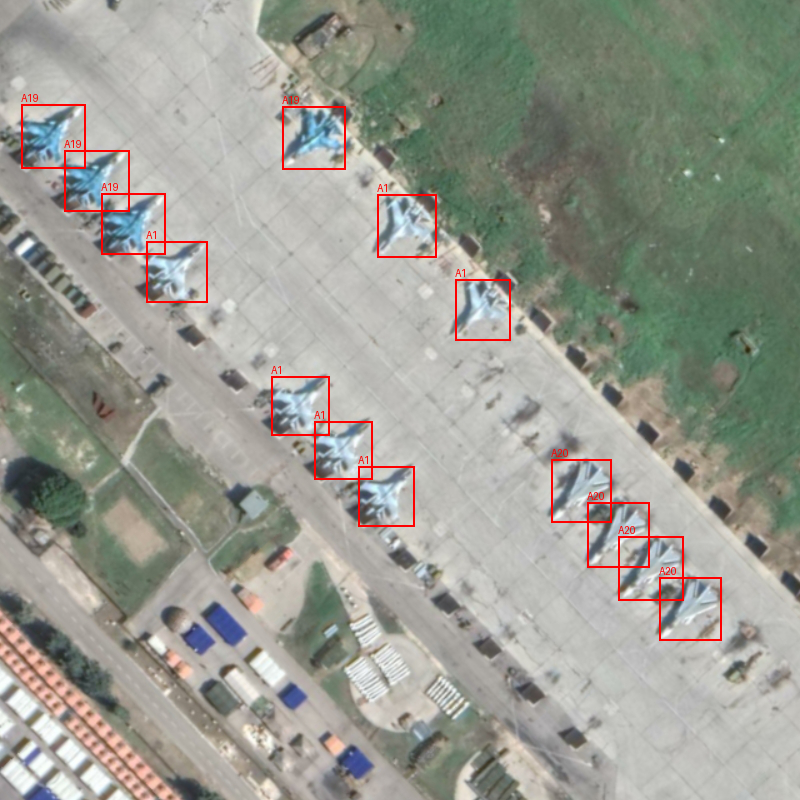

In [35]:
import os
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

data_dir = r"C:\Users\prath\OneDrive\Desktop\project"


def find_image_path(data_dir, file_id):
    jpg_dir = os.path.join(data_dir, "JPEGImages")
    exts = [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"]
    candidates = [file_id, file_id.zfill(3), file_id.zfill(4), file_id.zfill(5)]
    for cand in candidates:
        for ext in exts:
            p = os.path.join(jpg_dir, cand + ext)
            if os.path.exists(p):
                return p
    return None

def find_annotation_path(data_dir, file_id):
    
    possible_dirs = [
        os.path.join(data_dir, "Annotations"),
        os.path.join(data_dir, "Annotations", "Horizontal Bounding Boxes"),
        os.path.join(data_dir, "Annotations", "vertical_bboxes")  # just in case
    ]
    for d in possible_dirs:
        p = os.path.join(d, file_id + ".xml")
        if os.path.exists(p):
            return p
    return None


train_txt = os.path.join(data_dir, "ImageSets", "Main", "train.txt")
with open(train_txt, "r") as f:
    train_filenames = [line.strip() for line in f.read().splitlines() if line.strip()]


found_ids = []
missing_ids = []
found_img_paths = {}  
for fid in train_filenames:
    img_p = find_image_path(data_dir, fid)
    if img_p:
        found_ids.append(fid)
        found_img_paths[fid] = img_p
    else:
        missing_ids.append(fid)

print(f"Total IDs listed in train.txt: {len(train_filenames)}")
print(f"Found images for: {len(found_ids)} IDs")
print(f"Missing images for: {len(missing_ids)} IDs")
if missing_ids:
    print("First 20 missing IDs:", missing_ids[:20])

found_with_ann = [fid for fid in found_ids if find_annotation_path(data_dir, fid)]
print(f"Of found images, {len(found_with_ann)} have annotation XMLs (checked common locations).")


train_data, train_obj_dims = read_data(found_ids) 

if len(train_data) == 0:
    raise RuntimeError("read_data returned empty train_data. Check read_data implementation.")
img, objects = train_data[0]
if img.mode != 'RGB':
    img = img.convert('RGB')

draw = ImageDraw.Draw(img)
try:
    font = ImageFont.load_default()
except Exception:
    font = None

for obj in objects:
    label, bbox = obj[0], obj[1]
    bbox = tuple(int(x) for x in bbox)
    draw.rectangle(bbox, outline='red', width=2)
    text_pos = (bbox[0], max(0, bbox[1] - 12))
    draw.text(text_pos, str(label), fill='red', font=font)

display(img)


In [36]:
def pad_img(img):
    
    old_size = img.size
    
    # Define the desired size to transform the image to
    desired_size = (64,64)
    
    # Calculate the maximum dimension of the original image
    max_dim = max(old_size)
    
    # Create a new image with the max_dim as the width and height
    padded = Image.new("RGB", (max_dim, max_dim))
    
    # Calculate the padding for the image to make it square
    x = (max_dim - old_size[0]) // 2
    y = (max_dim - old_size[1]) // 2
    
    # Paste the original image onto the padded image at the calculated position
    padded.paste(img, (x, y))
    
    # Resize the padded image to the desired size
    out_img = padded.resize(desired_size)
    
    # Return the transformed image
    return out_img

In [37]:
def extract_obj(img, annotations):
    '''
    This function extracts objects from an image based on provided annotations
    '''
    # Define lists to keep objects in an image and their labels
    objects = []
    labels = []
    
    # Loop through annotations, each of which contain a label and 
    # a bounding box denoted by 'b_box'
    for label, b_box in annotations:
        labels.append(label)
        roi = img.crop(b_box)
        
        # Add roi to the list
        objects.append(roi)
        
    
    # Convert labels to numpy array
    labels = np.array(labels)
    
    # Return objects as individual images as well as their labels
    return objects, labels

In [38]:
def preprocessing(data):
    
    # Define two temporary lists to store objects and labels
    X_temp = []
    y_temp = []
    
    # Iterate over images and annotations to prepare X_train and y_train
    for img, annotations in data:

        # Extract the objects from current image
        objects, labels = extract_obj(img, annotations)

        # Pad objects
        padded = []
        for obj in objects:
            padded_img = pad_img(obj)
            padded.append(padded_img)

        # Add the objects to two temporary lists
        X_temp.append(padded)
        y_temp.append(labels)

    # Flatten the list of labels and convert to numpy array
    orig_labels = list(itertools.chain(*y_temp))
    orig_labels_np = np.array(orig_labels).reshape(-1, 1)
    
    # Encode the labels
    encoder = OneHotEncoder()
    y = encoder.fit_transform(orig_labels_np).toarray()

    n_channels = 3
    
    X_list = []
    
    # Normalize and create a list of image arrays
    for img in X_temp:
        for obj in img:
            X_list.append(np.array(obj)/255.0)
    
    # Convert the list of images to an array
    X = np.array(X_list)
            
    return X, y, orig_labels_np

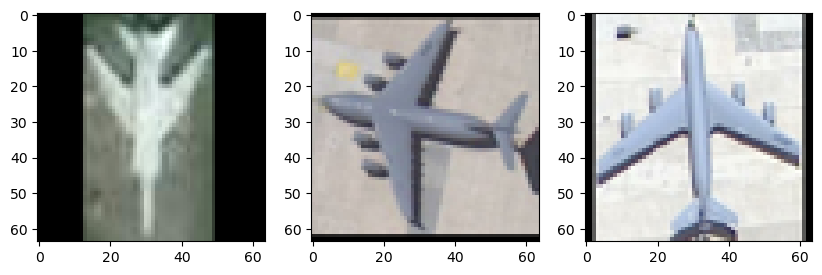

In [39]:
# Get features and labels
X, y, orig_labels = preprocessing(train_data)
n_labels = y.shape[1]

# Display some of the padded objects
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3))
ax0.imshow(X[np.argmin(train_obj_dims)//2], cmap='gray')
ax1.imshow(X[30], cmap='gray')
ax2.imshow(X[np.argmax(train_obj_dims)//2], cmap='gray')

In [40]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

# Shape check
print(Back.RESET + Fore.YELLOW + f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(Back.RESET + Fore.YELLOW + f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (5221, 64, 64, 3)
y_train.shape: (5221, 20)
X_test.shape: (2573, 64, 64, 3)
y_test.shape: (2573, 20)


In [41]:
# Define a model-building function
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                            input_shape=(64, 64, 3)))
    model.add(layers.AveragePooling2D((2, 2)))
    
    # Tune the number of convolutional layers
    for i in range(hp.Int('conv_layers', 1, 3)):
        model.add(layers.Conv2D(hp.Int(f'filters_{i}', 32, 128, step=32), 
                                (3, 3), activation='relu'))
        model.add(layers.AveragePooling2D((2, 2)))

    model.add(layers.Flatten())
    
    # Tune the number of units in the dense layer
    model.add(layers.Dense(hp.Int('units', 64, 256, step=32), 
                           activation='relu'))
    
    # Add a dropout layer
    model.add(layers.Dropout(hp.Float('dropout', 0.3, 0.6, step=0.1)))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    
    model.add(layers.Dense(n_labels, activation='softmax'))
    
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    
    return model

In [45]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,     # only 3 trials
    executions_per_trial=1,
    directory='my_dir',
    project_name='my_project'
)

tuner.search(X_train, y_train, epochs=2, validation_data=(X_test, y_test))


Trial 7 Complete [00h 00m 33s]
val_accuracy: 0.3089778423309326

Best val_accuracy So Far: 0.6750874519348145
Total elapsed time: 00h 05m 37s


In [46]:
# Print the best hyperparameters found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps}")

# Build and train the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x000001ECBA918150>
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - accuracy: 0.2639 - loss: 2.4034 - val_accuracy: 0.4030 - val_loss: 1.8907
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.5143 - loss: 1.5622 - val_accuracy: 0.6250 - val_loss: 1.2351
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.6309 - loss: 1.1706 - val_accuracy: 0.7093 - val_loss: 0.9129
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.7200 - loss: 0.8864 - val_accuracy: 0.7746 - val_loss: 0.7252
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.7606 - loss: 0.7336 - val_accuracy: 0.7847 - val_loss: 0.6732
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.8046 - loss: 0.5925 - val_accuracy: 0.7567 - val_loss: 0.7511
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - accuracy: 0.8322 - loss: 0.5113 - val_ac

In [50]:
# First, install the required packages and make sure they're properly installed
!pip install pydot
!pip install graphviz
# Also install python-graphviz which is often needed alongside pydot
!pip install python-graphviz

# After installation, restart the kernel
# Note: You'll need to manually restart the kernel here
# After restarting, run the code below

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG

# Test the model
# Make sure your model, X_test, and y_test are defined before this point
loss, accuracy = model.evaluate(X_test, y_test)

# Try to plot the model
try:
    plot_model(model, to_file='basic_model.png')
    print("Model plot saved as basic_model.png")
except Exception as e:
    print(f"Error plotting model: {e}")

# Try the alternative way to display the model
try:
    SVG(model_to_dot(model).create(prog='dot', format='svg'))
except Exception as e:
    print(f"Error creating SVG: {e}")

# Display model summary and metrics
model.summary()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

ERROR: Could not find a version that satisfies the requirement python-graphviz (from versions: none)
ERROR: No matching distribution found for python-graphviz


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8632 - loss: 0.4801
You must install pydot (`pip install pydot`) for `plot_model` to work.
Model plot saved as basic_model.png
Error creating SVG: You must install pydot (`pip install pydot`) for model_to_dot to work.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 31, 31, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 96)     │        27,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 14, 14, 96)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 32)     │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 6, 6, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,069,886 (4.08 MB)

 Trainable params: 356,628 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 713,258 (2.72 MB)

Test Loss: 0.48006775975227356
Test Accuracy: 0.8631947040557861


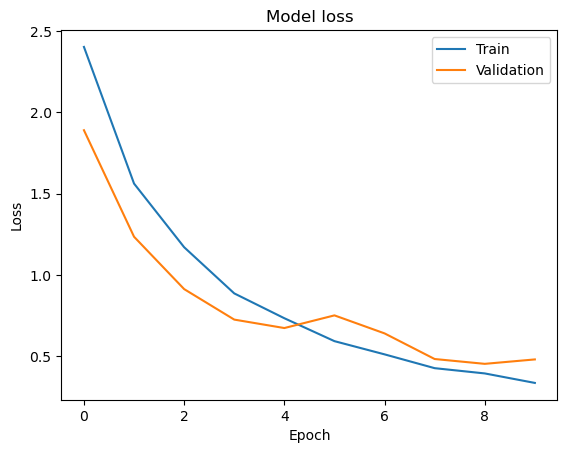

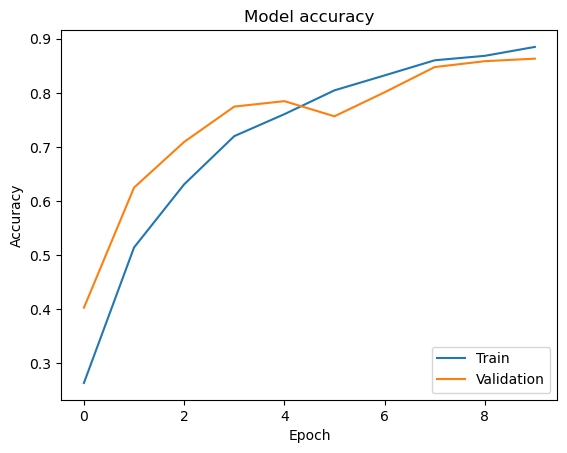

In [51]:
# Plot the performance of the model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


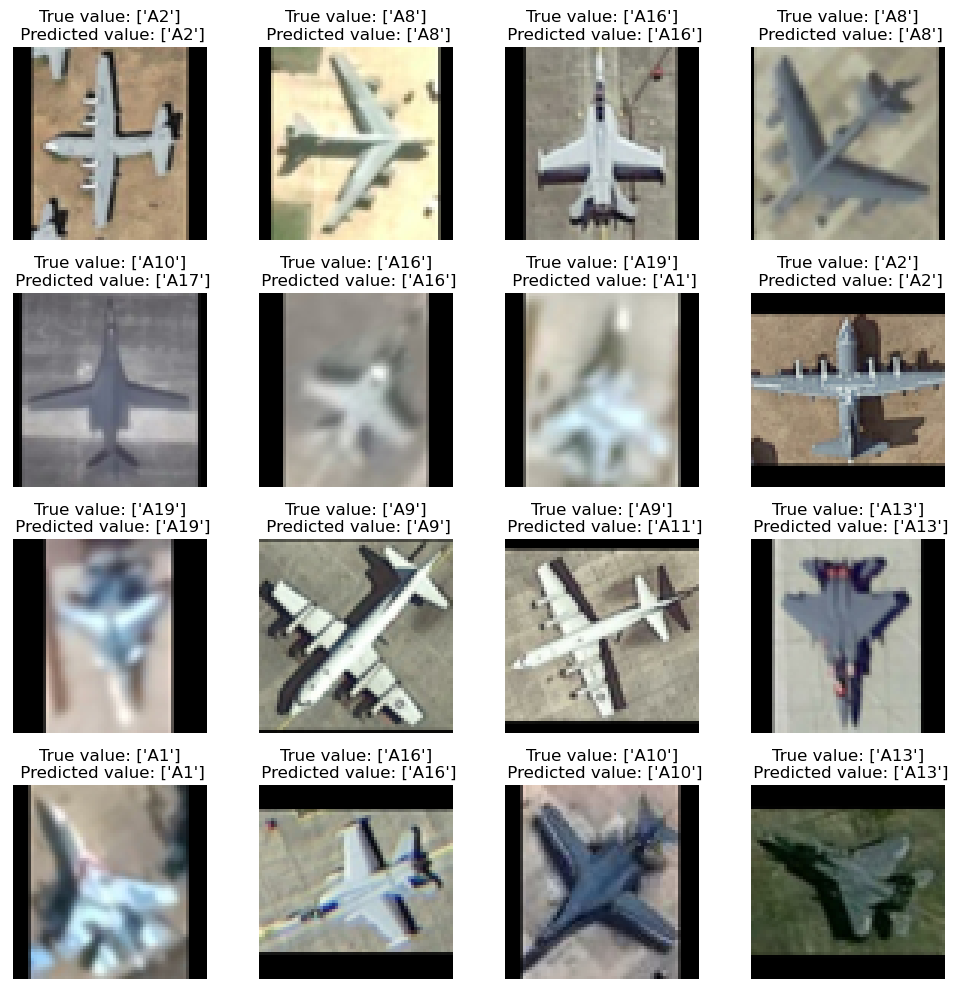

In [52]:
# Pridict
predictions = model.predict(X_test)

# Create a new instance of OneHotEncoder
encoder = OneHotEncoder()

# Fit the encoder on the original categorical labels
encoder.fit(orig_labels)

# Perform the inverse transformation using the OneHotEncoder
y_orig_true = encoder.inverse_transform(y_test)
y_orig_pred = encoder.inverse_transform(predictions)

# Display 16 predictions

# Set up the subplots
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.ravel()

# Generate some random indices
random_numbers = []
for _ in range(16):
    random_number = random.randint(0, X_test.shape[0])
    random_numbers.append(random_number)
    
for i, rand in enumerate(random_numbers):
    axs[i].imshow(X_test[rand], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"True value: {y_orig_true[rand]}\n Predicted value: {y_orig_pred[rand]}")

plt.tight_layout()
plt.show()

DataFrame of metrics (first 10 rows):


,loss,val_loss,accuracy,val_accuracy
1,2.403376,1.890696,0.263934,0.403031
2,1.562242,1.235058,0.514269,0.624951
3,1.170575,0.912881,0.630914,0.709289
4,0.886437,0.725182,0.719977,0.774582
5,0.733569,0.673211,0.760582,0.784687
6,0.592519,0.751150,0.804635,0.756704
7,0.511270,0.640302,0.832216,0.801010
8,0.426238,0.482550,0.860180,0.847649
9,0.393902,0.452872,0.868416,0.858531
10,0.335458,0.480068,0.884888,0.863195


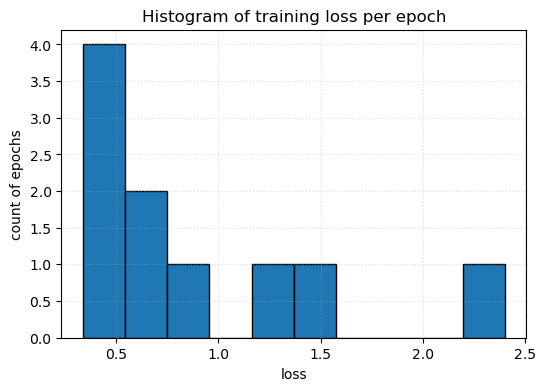

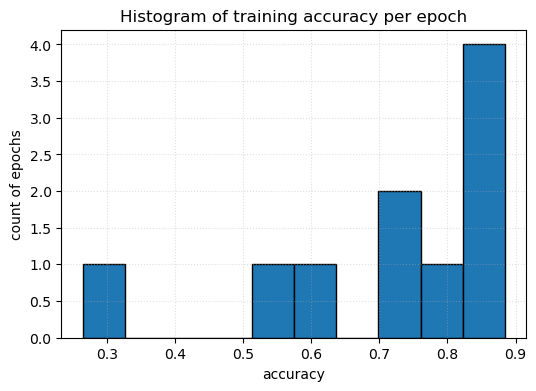

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------- replace this with your actual history -------------------
# Example: history = model.fit(...)
# This code expects a Keras History object or a dict like history.history
# -----------------------------------------------------------------------------
# If you already have a Keras History object, use:
# hist_dict = history.history
# If you have only a dict, set hist_dict = your_dict
try:
    hist_dict = history.history  # history is the Keras History object
except NameError:
    # fallback if `history` variable doesn't exist; try using a dictionary named 'history_dict'
    hist_dict = globals().get('history_dict', None)
    if hist_dict is None:
        raise RuntimeError("No `history` or `history_dict` found. Run model.fit(...) and store the result in `history`.")
# -----------------------------------------------------------------------------


# canonicalize keys (handle 'acc' vs 'accuracy', etc.)
keys_map = {}
for k in list(hist_dict.keys()):
    lc = k.lower()
    if lc == 'acc':
        keys_map[k] = 'accuracy'
    elif lc == 'val_acc':
        keys_map[k] = 'val_accuracy'
    else:
        keys_map[k] = k  # keep as is

# build a normalized dict with canonical keys
normalized = {}
for orig_k, canon_k in keys_map.items():
    normalized[canon_k] = np.array(hist_dict[orig_k])

# create dataframe: columns we care about (if present)
cols = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
data = {}
for c in cols:
    if c in normalized:
        data[c] = normalized[c]
# turn into DataFrame (index = epoch number starting from 1)
df = pd.DataFrame(data)
df.index = np.arange(1, len(df) + 1)
print("DataFrame of metrics (first 10 rows):")
display(df.head(10))

# ---------- 1) Histograms for training loss and accuracy ----------
if 'loss' in df.columns:
    plt.figure(figsize=(6,4))
    plt.hist(df['loss'].dropna(), bins=min(30, max(5, len(df)//1)), edgecolor='black')
    plt.title('Histogram of training loss per epoch')
    plt.xlabel('loss')
    plt.ylabel('count of epochs')
    plt.grid(True, linestyle=':', alpha=0.4)
    plt.show()

if 'accuracy' in df.columns:
    plt.figure(figsize=(6,4))
    plt.hist(df['accuracy'].dropna(), bins=min(30, max(5, len(df)//1)), edgecolor='black')
    plt.title('Histogram of training accuracy per epoch')
    plt.xlabel('accuracy')
    plt.ylabel('count of epochs')
    plt.grid(True, linestyle=':', alpha=0.4)
    plt.show()


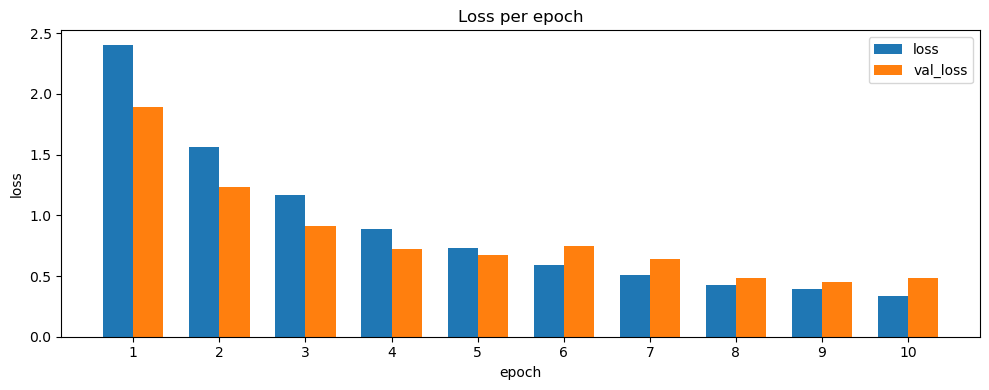

In [54]:
if 'loss' in df.columns:
    plt.figure(figsize=(10,4))
    x = np.arange(len(df))
    width = 0.35
    plt.bar(x - width/2, df['loss'], width, label='loss')
    if 'val_loss' in df.columns:
        plt.bar(x + width/2, df['val_loss'], width, label='val_loss')
    plt.title('Loss per epoch')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xticks(x, df.index)
    plt.legend()
    plt.tight_layout()
    plt.show()

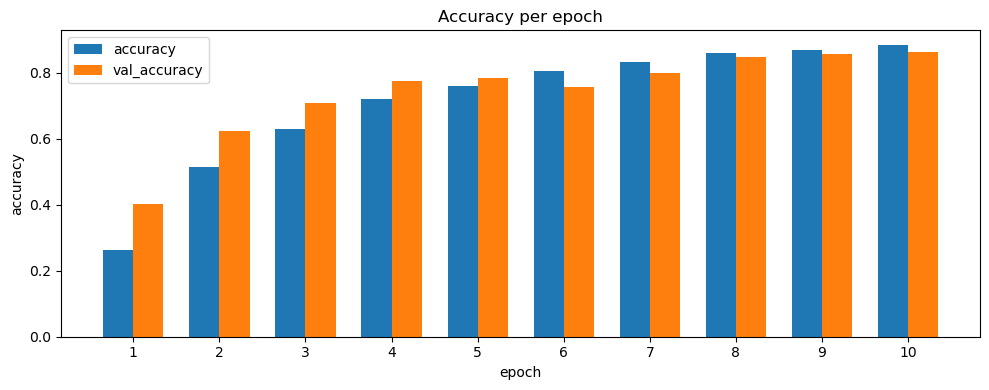

In [55]:
if 'accuracy' in df.columns:
    plt.figure(figsize=(10,4))
    x = np.arange(len(df))
    width = 0.35
    plt.bar(x - width/2, df['accuracy'], width, label='accuracy')
    if 'val_accuracy' in df.columns:
        plt.bar(x + width/2, df['val_accuracy'], width, label='val_accuracy')
    plt.title('Accuracy per epoch')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.xticks(x, df.index)
    plt.legend()
    plt.tight_layout()
    plt.show()


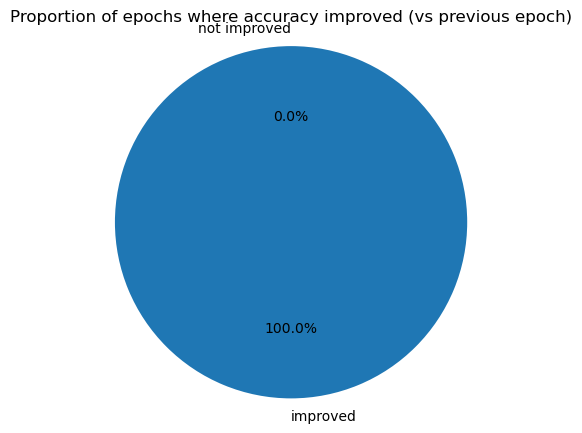

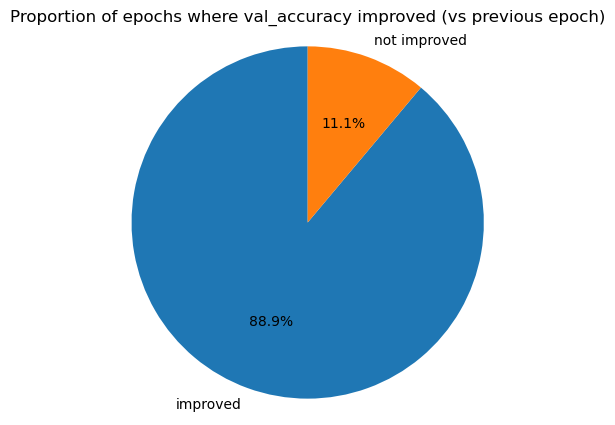

In [56]:
def improvement_pie(series, name='accuracy'):
    dif = series.diff().dropna()
    improved = int((dif > 0).sum())
    not_improved = int((dif <= 0).sum())
    labels = ['improved', 'not improved']
    sizes = [improved, not_improved]
    if sum(sizes) == 0:
        print(f"No data to make pie chart for {name}.")
        return
    plt.figure(figsize=(5,5))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(f'Proportion of epochs where {name} improved (vs previous epoch)')
    plt.axis('equal')
    plt.show()
    
if 'accuracy' in df.columns and len(df['accuracy'])>1:
    improvement_pie(df['accuracy'], 'accuracy')
if 'val_accuracy' in df.columns and len(df['val_accuracy'])>1:
    improvement_pie(df['val_accuracy'], 'val_accuracy')

Correlation matrix (numeric):


,loss,val_loss,accuracy,val_accuracy
loss,1.000000,0.985945,-0.999934,-0.983659
val_loss,0.985945,1.000000,-0.985880,-0.998730
accuracy,-0.999934,-0.985880,1.000000,0.983735
val_accuracy,-0.983659,-0.998730,0.983735,1.000000


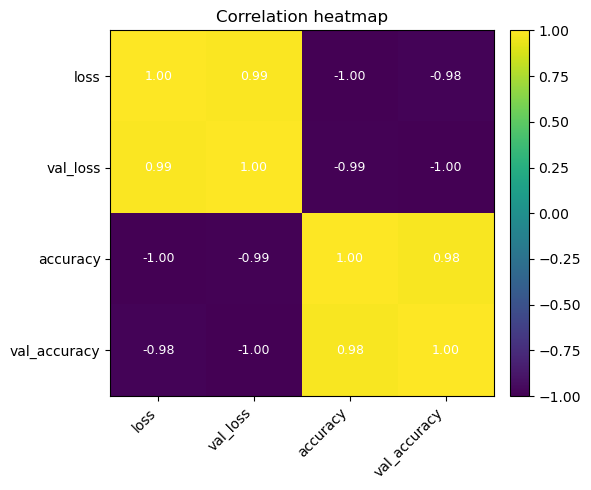

In [57]:
metrics_df = df.copy()
# keep only numeric columns
metrics_df = metrics_df.select_dtypes(include=[np.number])
if metrics_df.shape[1] >= 2:
    corr = metrics_df.corr()
    print("Correlation matrix (numeric):")
    display(corr)

    # draw heatmap with matplotlib imshow and annotated values
    plt.figure(figsize=(6,5))
    im = plt.imshow(corr.values, vmin=-1, vmax=1, aspect='auto')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    ticks = np.arange(len(corr.columns))
    plt.xticks(ticks, corr.columns, rotation=45, ha='right')
    plt.yticks(ticks, corr.columns)
    plt.title('Correlation heatmap')
    # annotate values
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            plt.text(j, i, f"{corr.values[i, j]:.2f}", ha='center', va='center', fontsize=9, color='w' if abs(corr.values[i,j])>0.5 else 'k')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric metric columns to compute correlation/heatmap.")


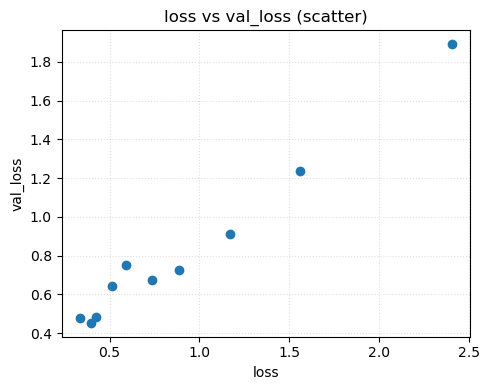

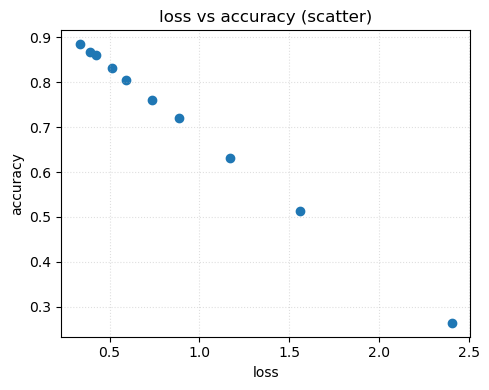

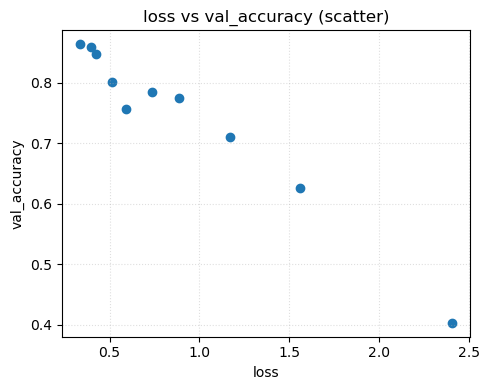

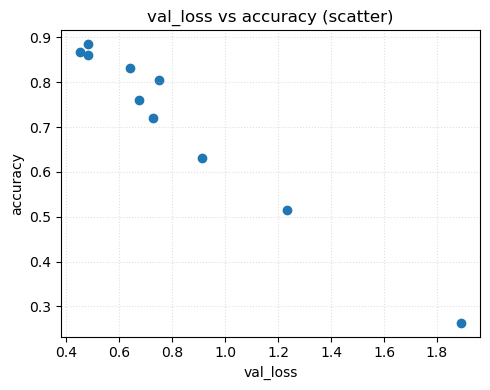

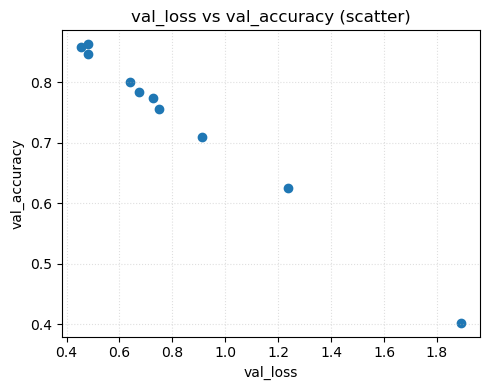

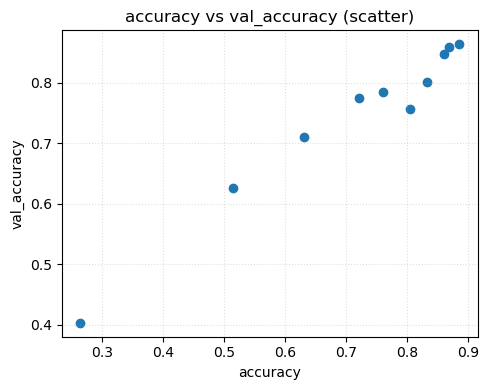

In [58]:
cols_for_pairs = metrics_df.columns.tolist()
n = len(cols_for_pairs)
for i in range(n):
    for j in range(i+1, n):
        a = cols_for_pairs[i]
        b = cols_for_pairs[j]
        plt.figure(figsize=(5,4))
        plt.scatter(metrics_df[a], metrics_df[b])
        plt.xlabel(a)
        plt.ylabel(b)
        plt.title(f'{a} vs {b} (scatter)')
        plt.grid(True, linestyle=':', alpha=0.4)
        plt.tight_layout()
        plt.show()